# Выбор локации для скважины

Нефтедобывающая компания хочет определить регион, где добыча принесёт наибольшую прибыль.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

*Замечание*: Данные синтетические

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Регион-0" data-toc-modified-id="Регион-0-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Регион 0</a></span></li><li><span><a href="#Регион-1" data-toc-modified-id="Регион-1-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Регион 1</a></span></li><li><span><a href="#Регион-2" data-toc-modified-id="Регион-2-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Регион 2</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span><ul class="toc-item"><li><span><a href="#Условия" data-toc-modified-id="Условия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Условия</a></span></li><li><span><a href="#Расчет-прибыли" data-toc-modified-id="Расчет-прибыли-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Расчет прибыли</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Загрузка и подготовка данных

In [1]:
#импорт необходимых библиотек
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

Даанные геологоразведки трёх регионов находятся в разных файлах. Сформируем отдельно три датасета:

In [2]:
geo_data_0 = pd.read_csv('datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('datasets/geo_data_2.csv')

Данные для всех трех регионов имеют одинаковую структуру:
- `id` — уникальный идентификатор скважины
- `f0`, `f1`, `f2` — три значимых признака точек
- `product` — объём запасов в скважине (тыс. баррелей)

In [3]:
# функция для получения основной информации о датасете
def get_info(data):
    display(data.head(2))
    
    print("Shape:", data.shape, '\n')
    print("Количество пропусков в данных:\n", data.isna().sum(), '\n', sep='')
    print("Количество дубликатов:", data.duplicated().sum(), '\n')
    
    fig, axes = plt.subplot_mosaic(
        [["f0","f1","f2"],
         ["product", "product", "product"]]
    )
    
    fig.set_figheight(8)
    fig.set_figwidth(15)
    
    print("Распределения значений:")    
    for key in ["f0","f1","f2"]:
        data[key].hist(bins=50, ax=axes[key], color='#B0ADAA', grid=False)
        axes[key].set_title(key)
        axes[key].set_ylim(0, 20_000)
    
    data["product"].hist(bins=200, range=(0, 200), ax=axes["product"], color='#E3C04D', grid=False)
    axes["product"].set_title('product')
        

Датасет № 0:

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750


Shape: (100000, 5) 

Количество пропусков в данных:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов: 0 

Распределения значений:


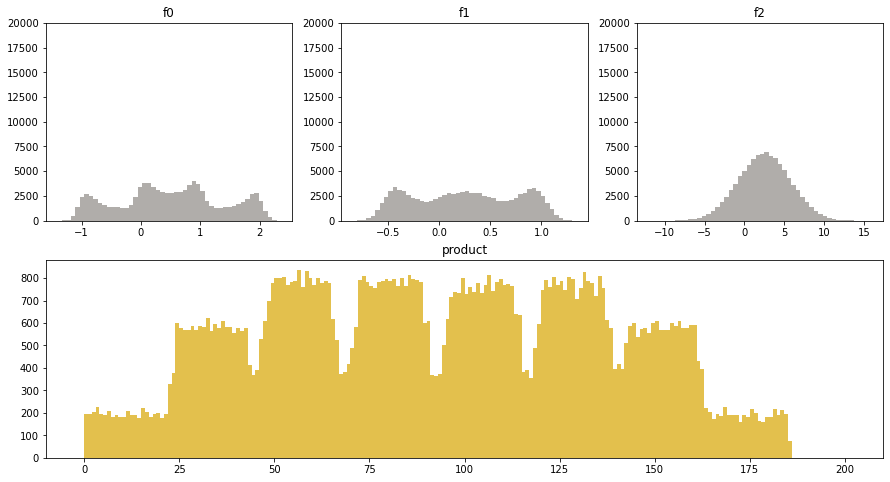

In [4]:
get_info(geo_data_0)

Пропусков и дубликатов в датасете нет. Распределения f0 и f1 являются полимодальными, в то время как распределение f1 является нормальным. Распределение запаса имеет ярковыраженные "столбцы" с равномерным распределением в пределах диапазона, перемежающиеся с локальными минимумами.

Датасет № 1:

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


Shape: (100000, 5) 

Количество пропусков в данных:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов: 0 

Распределения значений:


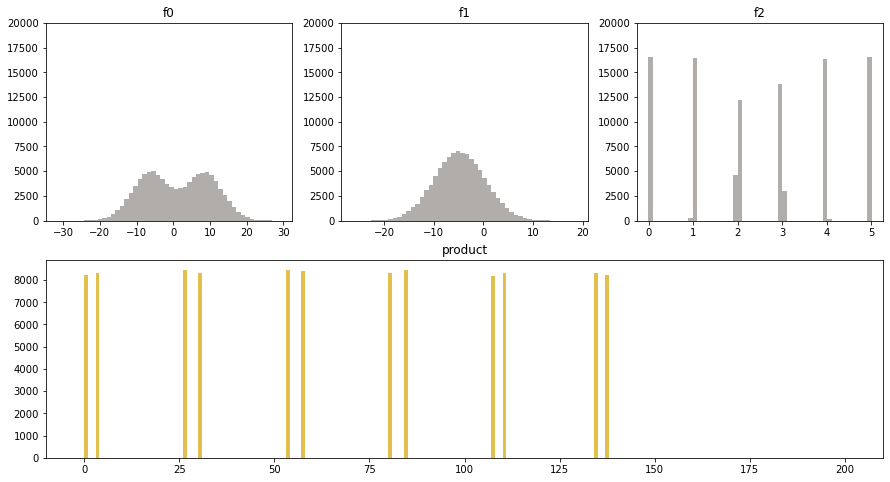

In [5]:
get_info(geo_data_1)

Пропусков и дубликатов в датасете нет. а0 имеет бимодальное рампределение. Распределение f1 является нормальным. Можно сказать, что f2 имеет практически дискретное равномерное распределение:

In [6]:
geo_data_1['f2'].round(0).value_counts(normalize=True)

 2.0    0.16862
 1.0    0.16774
 3.0    0.16751
-0.0    0.16572
 5.0    0.16537
 4.0    0.16504
Name: f2, dtype: float64

Распределение запаса имеет похожую структуру:

In [7]:
geo_data_1['product'].round(0).value_counts(normalize=True)

54.0     0.08472
27.0     0.08468
84.0     0.08431
57.0     0.08390
3.0      0.08337
81.0     0.08320
30.0     0.08306
135.0    0.08304
111.0    0.08303
0.0      0.08235
138.0    0.08233
108.0    0.08201
Name: product, dtype: float64

Датасет № 2:

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


Shape: (100000, 5) 

Количество пропусков в данных:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов: 0 

Распределения значений:


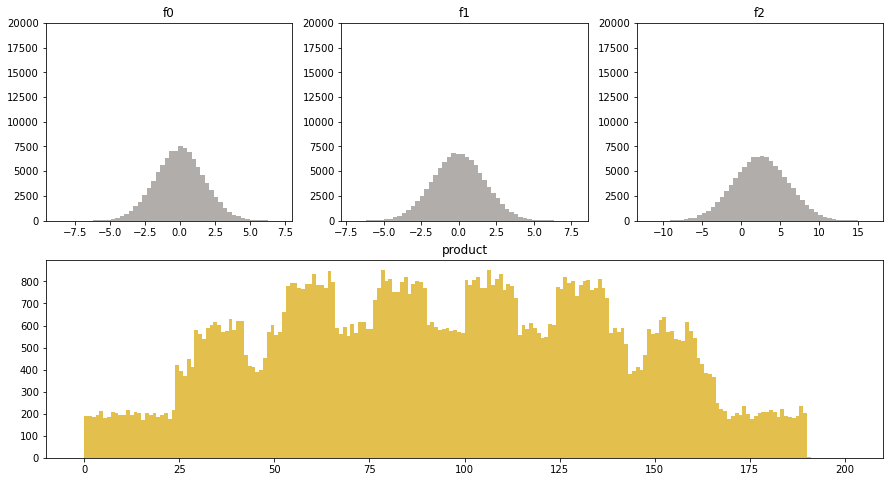

In [8]:
get_info(geo_data_2)

Пропусков и дубликатов в датасете нет. Распределения f0, f1 и f2 являются нормальными. Распределение запаса имеет ярковыраженные "столбцы" с равномерным распределением в пределах каждого диапазона, перемежающиеся с локальными минимумами.

### Выводы

В рамках этапа были рассмотрены данные по всем 3 регионам. Все данные полные и не требуют предобработки. Для каждого региона распределения величин `f0`, `f1`, `f2` и `product` имеют свои особенности.

## Обучение и проверка модели

### Подготовка признаков

Столбец `id` является идентификационным и не несет информации о запасах в скважине, в качестве признаков используются `f0`, `f1` и `f2`. Целевым является столбец `product`. Все данные должны быть разделены на обучающую и валидационную выборки в соотношении 3:1.

In [9]:
def features_n_targets(data):
    
    features = data.drop(['id', 'product'], axis=1)    
    target = data['product']    

    return  train_test_split(features, target, test_size=.75, random_state=1)

features_valid_0, features_train_0, target_valid_0, target_train_0 = features_n_targets(geo_data_0)
features_valid_1, features_train_1, target_valid_1, target_train_1 = features_n_targets(geo_data_1)
features_valid_2, features_train_2, target_valid_2, target_train_2 = features_n_targets(geo_data_2)

print('Обучающая выборка:', features_train_0.shape[0], 'строк')
print('Валидационная выборка:', features_valid_0.shape[0], 'строк')

Обучающая выборка: 75000 строк
Валидационная выборка: 25000 строк


### Обучение модели

Для обучения модели подходит только линейная регрессия, так как остальные модели недостаточно предсказуемые. 

In [10]:
def get_predictions(features_valid, features_train, target_valid, target_train):

    lr = LinearRegression()
    lr.fit(features_train, target_train)
    
    predictions = pd.Series(lr.predict(features_valid), index=target_valid.index)
    
    rmse = mean_squared_error(predictions, target_valid) ** 0.5
    avg = predictions.mean()
    
    print("RMSE: {0:.2f}".format(rmse))
    print("Average product: {0:.2f}".format(avg))
    print('R\u00b2 = {0:.2f}'.format( r2_score(target_valid,predictions)))
    
    return predictions, avg, rmse

#### Регион 0

In [11]:
summary = {}
predictions_0, *summary['Регион 0'] =\
    get_predictions(features_valid_0, features_train_0, target_valid_0, target_train_0)

RMSE: 37.58
Average product: 92.53
R² = 0.28


Визуально оценим качество модели. Построим график, отображающий предсказаное значение относительно действительного.

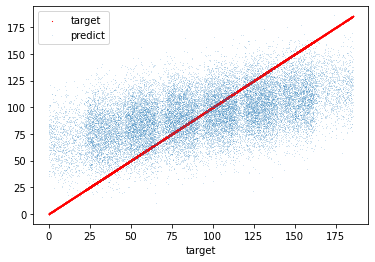

In [12]:
def plot_target_vs_predict(target, predictions):

    plt.scatter(target, target, label='target',  marker=".", lw=0.7, s=1, c='r')
    plt.scatter(target, predictions, label='predict', marker=",", lw=0, s=1, alpha=0.2)
    plt.xlabel('target')
    plt.legend()
    None

plot_target_vs_predict(target_valid_0, predictions_0)

Видно, что на всем диапазоне значений реального запаса предсказания можели имеют большой разброс относительно искомого значения, причем на экстримальных зачениях это отклонение наибольшее. Потенциально это повышает риски, так как предсказанные значения отличаются от реальных.

#### Регион 1

In [13]:
predictions_1, *summary['Регион 1'] =\
    get_predictions(features_valid_1, features_train_1, target_valid_1, target_train_1)

RMSE: 0.89
Average product: 68.64
R² = 1.00


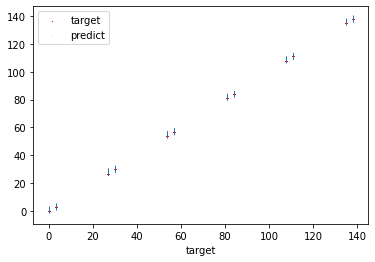

In [14]:
plot_target_vs_predict(target_valid_1, predictions_1)

Модель демонстрирует высокое качество на всем диапазоне данных: значения по предсказаниям мало отличаются от реальных, и RMSE близка к 0.

#### Регион 2

In [15]:
predictions_2, *summary['Регион 2'] =\
    get_predictions(features_valid_2, features_train_2, target_valid_2, target_train_2)

RMSE: 40.14
Average product: 94.99
R² = 0.20


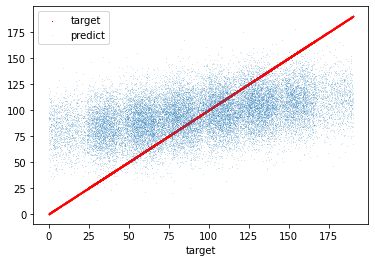

In [16]:
plot_target_vs_predict(target_valid_2, predictions_2)

Видно, что на всем диапазоне значений реального запаса предсказания можели имеют большой разброс относительно искомого значения, причем на экстремальных зачениях это отклонение наибольшее. Потенциально это повышает риски, так как предсказанные значения отличаются от реальных.

### Выводы

На данном этапе были подготовлены признаки для обучения моделей и обучены модели для всех трех регионов.

In [17]:
pd.options.display.float_format = '{:,.2f}'.format #dataframe output formatting
pd.DataFrame(summary.values(), index=summary.keys(), columns=['Средний запас', 'RMSE'])

,Средний запас,RMSE
Регион 0,92.53,37.58
Регион 1,68.64,0.89
Регион 2,94.99,40.14


Предсказанные значения запасов для скважин 0 и 2 намного выше, чем для 1. Однако точность предсказаний для скважины 1 очень высокая: RMSE близка к 0, в то время как для других составляет около 40% от среднего значения.

## Расчёт прибыли и рисков 

###  Условия
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [18]:
budget = 10_000_000_000 #рублей

burrel_price = 450 #рублей
income_per_1 = burrel_price * 1000 #рублей

n_explored = 500
n_best = 200

In [19]:
min_product = budget/ income_per_1
print("Точка безубыточности: {0:.0f} тыс. баррелей".format(min_product))

Точка безубыточности: 22222 тыс. баррелей


In [20]:
print("Средний объем нефти в выбранных скважинах для безубыточного функционирования:",\
      np.ceil(min_product/n_best), 'тыс. баррелей')

Средний объем нефти в выбранных скважинах для безубыточного функционирования: 112.0 тыс. баррелей


Во всех трех регионах средний запас в скважине меньше, чем требуется для безубыточной разработки. Однако при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки, поэтому среднее для них будет выше.

### Расчет прибыли

In [21]:
def get_income(predictions, target):
    
    #скважины с максимальными значениями предсказаний.
    top = predictions.sort_values(ascending=False).index[:n_best]
    
    #4.3. Рассчитайте доход для полученного объёма сырья
    return target[top].sum() * income_per_1

In [22]:
def Bootstrap(predictions, target, n):
    
    #Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    state = np.random.RandomState(1)
    incomes = []
    count = 0
    for _ in range(n):
        ind = predictions.sample(n=n_explored, replace=True, random_state=state).index
        income = get_income(predictions.loc[ind], target.loc[ind])
        incomes.append(income)
        if income < budget:
            count +=1
    
    incomes = pd.Series(incomes)
    
    #Средняя прибыль, 95%-й доверительный интервал и риск убытков.
    lower = incomes.quantile(0.025) - budget
    avg = incomes.mean() - budget
    upper = incomes.quantile(0.975) - budget    
    loss_prob = (incomes < budget).mean()
    
    print(f'Средняя прибыль: {int(avg):,} рублей'.replace(',',' '))
    print(f'Доверительный интервал: ({int(lower):,} - {int(upper):,}) рублей'.replace(',',' '))
    print(f'Вероятность убытков: {round(loss_prob*100, 1)}%')
    
    return lower, avg, upper, loss_prob    

In [23]:
summary_business = {}

summary_business['Регион 0'] = Bootstrap(predictions_0, target_valid_0, 1000)

Средняя прибыль: 662 067 616 рублей
Доверительный интервал: (81 523 899 - 1 282 939 086) рублей
Вероятность убытков: 1.0%


In [24]:
summary_business['Регион 1'] = Bootstrap(predictions_1, target_valid_1, 1000)

Средняя прибыль: 667 119 928 рублей
Доверительный интервал: (157 340 048 - 1 208 021 184) рублей
Вероятность убытков: 0.5%


In [25]:
summary_business['Регион 2'] = Bootstrap(predictions_2, target_valid_2, 1000)

Средняя прибыль: 561 529 521 рублей
Доверительный интервал: (-20 810 809 - 1 187 983 169) рублей
Вероятность убытков: 2.9%


### Выводы

In [26]:
summary_business = pd.DataFrame(summary_business.values(), 
                                index=summary_business.keys(), 
                                columns=['lower', 'avg', 'upper', 'loss_prob']
                               )

#output formatting
for col in ['lower', 'avg', 'upper']:
    summary_business[col] = summary_business[col].map('{:,.0f}'.format)
    
summary_business['loss_prob'] = summary_business['loss_prob'].map('{:,.3f}'.format)

summary_business

,lower,avg,upper,loss_prob
Регион 0,"81,523,899","662,067,617","1,282,939,086",0.010
Регион 1,"157,340,048","667,119,929","1,208,021,185",0.005
Регион 2,"-20,810,810","561,529,522","1,187,983,170",0.029


Риск для регионов 0 и 1 меньше требуемых 2.5%. Регион 2 не подходит, так как имеет слишком высокий риск. Регион 1 имеет наибольшие значения средней потенциальной прибыли и нижней границы доверительного интервала. Регион 0 имеет более широкий доверительный интервал, и, как следствие, более высокую верхнюю границу прибыли, однако и риски для него выше. В целом регион 1 является более надежным выбором.

## Выводы

Все данные полные и не требуют предобработки. 

Столбец `id` является идентификационным и не несет информации о запасах в скважине, в качестве признаков используются `f0`, `f1` и `f2`. Целевым является столбец `product`. Все данные должны быть разделены на обучающую и валидационную выборки в соотношении 75:25.

Для обучения модели подходит только линейная регрессия, так как остальные модели недостаточно предсказуемые.

В рамках проекта были изучены начальные данные: пропусков и дубликатов не обнаружено. Для каждого региона распределения признаков и запасов имеют свои особенности.

Были обучены модели линейной регрессии на данных для каждого региона в отдельности. Наиболее точными оказались предсказания для региона 1.

Так же был выполнен расчет рисков и потенциальной прибыли для каждого региона техникой Bootstrap с 1000 выборок. Была определена средняя прибыль, 95%-й доверительный интервал и риск убытков. 

В результате исследования было определено, что регион 1 является наиболее надежным и имеет наибольшую среднюю прибыль.